In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import clear_output
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from nltk import sent_tokenize, word_tokenize 
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn.utils.rnn import pad_sequence
from dataclasses import dataclass
from torch.utils.data import DataLoader
from torch.optim import Adam

# Enable interactive mode
plt.ion() 

def plot_losses(train_losses, val_losses):
    clear_output(wait=True)  # Clear previous output in Jupyter
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('N Batches')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Tokenization
def tokenize(text):
    return text.split()

def nltk_tokenize(text):
    sentences = sent_tokenize(text)
    return [word_tokenize(sent) for sent in sentences]

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenize(text)

# Build vocabulary
def build_vocab(texts):
    counter = dict()
    for text in texts:
        for word in text.split():
            counter[word] = counter.get(word, 0) + 1
    vocab = {token: idx + 1 for idx, token in enumerate(counter.keys())}
    vocab['<pad>'] = 0
    vocab['<unk>'] = len(vocab)
    print(f'Vocab length: {len(vocab)}')
    return vocab

def encode_texts(texts, vocab):
    return [torch.tensor([vocab.get(token, len(vocab)) for token in tokenize(text)]) for text in texts]


class NewsDatasetFixedLen(Dataset):
    def __init__(self, texts, labels, max_len):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts.values[idx]
        tokenized = tokenize(text)[:self.max_len]
        # tokenized += [0] * (self.max_len - len(tokenized))
        text = torch.tensor([vocab.get(token) for token in tokenized])
        label = torch.tensor(self.labels.values[idx], dtype=torch.float32)
        return text, label
        

def load_glove_embeddings(filepath):
    embeddings = {}
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

def load_fasttext_embeddings(filepath, embedding_dim):
    embeddings = {}
    with open(filepath, "r", encoding="utf-8") as f:
        next(f)  # Skip the first line (header)
        for line in f:
            values = line.split()
            word = values[0]  # The word
            vector = np.asarray(values[1:], dtype='float32')  # The embedding vector
            embeddings[word] = vector
    print(f"Loaded {len(embeddings)} word vectors.")
    return embeddings

def collate_fn(batch):
    texts, labels = zip(*batch)
    padded_sequence = pad_sequence(texts, batch_first=True)
    labels = torch.stack(labels)
    return padded_sequence, labels


# # Load GloVe embeddings
# glove_path = "/projappl/project_2006600/fin_experiment/embeddings/glove.6B.100d.txt"
# glove_embeddings = load_glove_embeddings(glove_path)
# print(f"Loaded {len(glove_embeddings)} word vectors.")

# Path to your FastText embedding file (e.g., cc.en.300.vec)
fasttext_path = "/projappl/project_2006600/fin_experiment/embeddings/crawl-300d-2M.vec"
embedding_dim = 300
fasttext_embeddings = load_fasttext_embeddings(fasttext_path, embedding_dim)


# Load data and split
data_dir = '/projappl/project_2006600/fin_experiment/data'
data_combined_news = pd.read_csv(os.path.join(data_dir, 'data_combined_news.csv'), sep='\t', encoding='utf-8')
vocab = build_vocab(data_combined_news['All_news_clean'])

embedding_dim = 300#100  # GloVe embedding dimension
vocab_size = len(vocab)


Loaded 1999995 word vectors.
Vocab length: 39104


In [3]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, texts, min_freq=5, reserved_tokens=[]):
        counter = dict()
        for text in texts:
            for word in text.split():
                counter[word] = counter.get(word, 0) + 1
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def get(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

In [5]:
vocab = Vocab(data_combined_news['All_news_clean'])
vocab_size = len(vocab)


In [73]:
vocab['woman'], vocab.get('woman')

(16130, 16130)

In [74]:
vocab.token_freqs[:10]


[('the', 63992),
 ('to', 52839),
 ('of', 46162),
 ('in', 46152),
 ('a', 32694),
 ('and', 25136),
 ('b', 23958),
 ('s', 20600),
 ('for', 19204),
 ('on', 15784)]

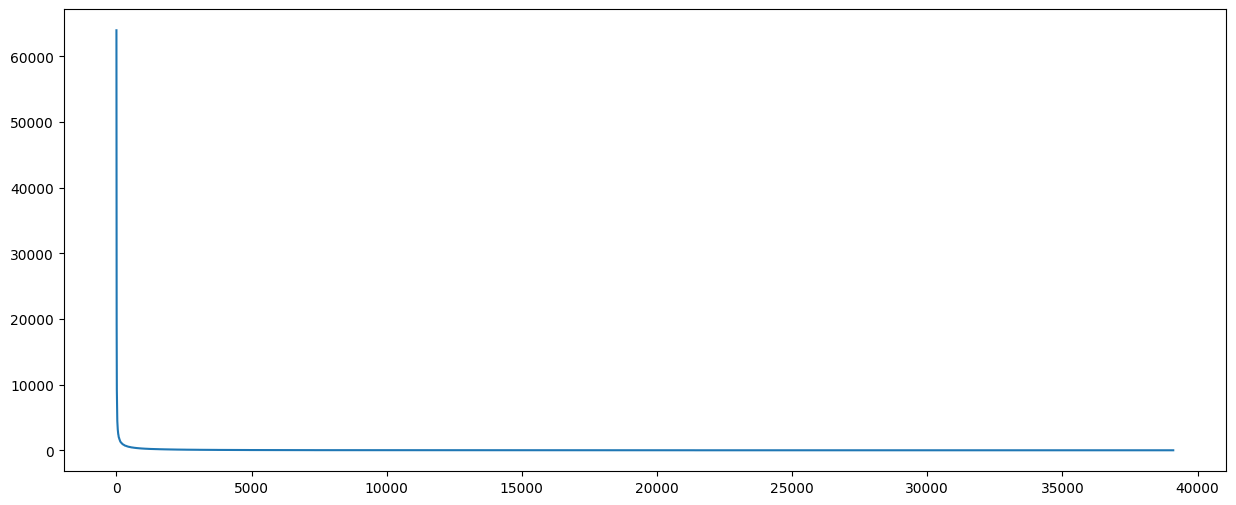

In [50]:
freqs = [freq for token, freq in vocab.token_freqs]
plt.figure(figsize=(15, 6))
plt.plot(freqs)

In [6]:
embedding_dim = 300#100  # GloVe embedding dimension
vocab_size = len(vocab)

# Initialize embedding matrix with random values
embedding_matrix = np.random.uniform(-0.01, 0.01, (vocab_size, embedding_dim))

# Fill the embedding matrix with GloVe embeddings
for word, idx in vocab.token_to_idx.items():
    if word in fasttext_embeddings:#glove_embeddings:
        embedding_matrix[idx] = fasttext_embeddings[word]
    elif word == "<pad>" or word == "<unk>":
        embedding_matrix[idx] = np.zeros(embedding_dim)  # Padding token

# Convert to PyTorch tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)


In [9]:
@dataclass
class TrainArgs:
    learning_rate: float
    batch_size: int
    epochs: int
    vocab_size: int
    emb_size: int
    hidden_dim: int
    num_classes: int
    bidirectional: bool
    num_layers: int

args = TrainArgs(1e-3, 32, 15, vocab_size, 300, 256, 1, False, 2)

x = data_combined_news['All_news_clean']
y = data_combined_news['Label']

X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)


train_dataset = NewsDatasetFixedLen(X_train, y_train, 500)
valid_dataset = NewsDatasetFixedLen(X_valid, y_valid, 500)

train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=args.batch_size, collate_fn=collate_fn)
    


In [10]:
# Setting device on GPU if available
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

torch.backends.cudnn.deterministic = True

Using device: cuda

NVIDIA A100-SXM4-40GB MIG 1g.5gb
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, hidden_states):
        """
        Args:
            hidden_states: Tensor of shape (batch_size, seq_length, hidden_dim)
        
        Returns:
            context: Tensor of shape (batch_size, hidden_dim)
        """
        # Compute attention scores (shape: batch_size, seq_length, 1)
        scores = self.attention(hidden_states)
        scores = torch.softmax(scores, dim=1)  # Normalize scores (shape: batch_size, seq_length, 1)

        # Weighted sum of hidden states (shape: batch_size, hidden_dim)
        context = torch.sum(scores * hidden_states, dim=1)  # Weighted sum along the sequence length
        return context


In [ ]:
import torch.nn.init as init


class BiLSTMForSentimentAnalysis(nn.Module):
    def __init__(self, params, pretrained_emb, dropout=0.3):
        super(BiLSTMForSentimentAnalysis, self).__init__()
        self.params = params
        if pretrained_emb is not None:
            self.embeddings = nn.Embedding.from_pretrained(pretrained_emb)
        else:
            self.embeddigns = nn.Embedding(params.vocab_size, params.emb_size)
        self.num_directions = 2 if self.params.bidirectional == True else 1

        self.embeddings.weight.requires_grad = False
        self.lstm = nn.LSTM(
            input_size=params.emb_size,
            hidden_size=params.hidden_dim,
            num_layers=params.num_layers,
            batch_first=True,
            bidirectional=params.bidirectional,
            dropout=dropout
        )
        self.attention = Attention(params.hidden_dim)
        self.dense = nn.Linear(params.hidden_dim * self.num_directions, params.num_classes)
        self.dropout = nn.Dropout(dropout)
        self.initialize_weights()
        
    def initialize_weights(self):
        # Initialize weights using Xavier initialization
        for name, param in self.lstm.named_parameters():
            if "weight_ih" in name:  # Input-to-hidden weights
                init.xavier_uniform_(param.data)
            elif "weight_hh" in name:  # Hidden-to-hidden weights
                init.xavier_uniform_(param.data)
            elif "bias" in name:  # Biases
                param.data.fill_(0)  # Set biases to zero
    
    def forward(self, x):
        x = self.embeddings(x)
        lstm_out, _ = self.lstm(x)  # Shape: (batch_size, seq_len, hidden_dim *2)
        
        #lstm_out = lstm_out[:, -1, :]  # Take the last time step's output from both directions
                
        # Fully connected + dropout
        context = self.attention(lstm_out)  # Shape: (batch_size, hidden_dim * 2)
        x = self.dropout(context)
        logits = self.dense(x)  # Shape: (batch_size, num_classes)
        return torch.squeeze(logits)


In [13]:
model = BiLSTMForSentimentAnalysis(args, pretrained_emb=embedding_matrix)

In [14]:
model

BiLSTMForSentimentAnalysis(
  (embeddings): Embedding(16358, 300)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.3)
  (attention): Attention(
    (attention): Linear(in_features=256, out_features=1, bias=True)
  )
  (dense): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
import torch.optim as optim

# Define optimizer, loss function, and device
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

loss_fn = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Move the model to the appropriate device
model.to(device)

def train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs):
    model.to(device)
    best_val_loss = float("inf")

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        # Training phase
        model.train()
        train_loss = 0
        for input_ids, labels in train_loader:
            input_ids, labels = input_ids.to(device), labels.to(device)
            
            optimizer.zero_grad()
            logits = model(input_ids)
            loss = loss_fn(logits, labels)
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            
        train_loss /= len(train_loader)
        print(f"Train Loss: {train_loss:.4f}")

        # Validation phase
        val_loss = evaluate_model(model, val_loader, loss_fn, device)
        print(f"Validation Loss: {val_loss:.4f}")
        scheduler.step(val_loss)

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("Saved best model.")


def evaluate_model(model, val_loader, loss_fn, device):
    model.eval()
    val_loss = 0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for input_ids, labels in val_loader:
            input_ids, labels = input_ids.to(device), labels.to(device)
            logits = model(input_ids)
            loss = loss_fn(logits, labels)
            val_loss += loss.item()
            probs = torch.sigmoid(logits)
            predictions = (probs > 0.5).float()
            # Update correct predictions
            running_corrects += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    acc = running_corrects / total_samples
    print(f'Validation accuracy: {acc}')

    val_loss /= len(val_loader)
    return val_loss


In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model
#train_model(model, train_dataloader, valid_dataloader, optimizer, loss_fn, device, args.epochs)